# Forward prediction of sentiment scores of Twitter replies




## Installs and imports

In [1]:
!pip install --upgrade pip
!pip install sentencepiece
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 

In [2]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification

from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties

from scipy.special import softmax
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd

## Load the Twitter datasets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Replies to Laroutrou

In [9]:
df1 = pd.read_csv (
    '/content/drive/My Drive/Twitter-Sentiment-Hate/replies-larrouturou-annotated-botometer.csv',
    low_memory=False,  
    lineterminator='\n', 
    sep=',',)
    #error_bad_lines=False)

In [6]:
df1.shape

(171, 49)

Replies to Alviina

In [8]:
df2 = pd.read_csv (
    '/content/drive/My Drive/Twitter-Sentiment-Hate/replies-alviinaalametsa-annotated-botometer.csv',
    low_memory=False,  
    lineterminator='\n', 
    sep=',',) 
    #error_bad_lines=False)

In [11]:
df2.shape

(113, 49)

In [10]:
df1.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'timezone', 'place',
       'tweet', 'language', 'hashtags', 'cashtags', 'user_id', 'user_id_str',
       'username', 'name', 'day', 'hour', 'link', 'urls', 'photos', 'video',
       'thumbnail', 'retweet', 'nlikes', 'nreplies', 'nretweets', 'quote_url',
       'search', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest', 'sentiment', 'annotator', 'annotation_id', 'updated_at',
       'lead_time', 'botometerCapEng.score', 'botometerCapUni.score',
       'botometerOverallRawEng.score', 'botometerOverallRawUni.score',
       'botometerDisplayEng.score', 'botometerDisplayUni.score'],
      dtype='object')

In [12]:
df1.head()

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,annotator,annotation_id,updated_at,lead_time,botometerCapEng.score,botometerCapUni.score,botometerOverallRawEng.score,botometerOverallRawUni.score,botometerDisplayEng.score,botometerDisplayUni.score
0,31706,1541498855061164034,2022-10-09T19:11:18.210103Z,2022-07-01 10:56:03,200,NaN,@larrouturou @zoo_bear @AltNews @PMOIndia @Ind...,en,[],[],...,2,281,2022-10-09T19:11:18.210132Z,25.844,0.447947,0.346921,0.09,0.05,0.4,0.2
1,31705,1541498855061164034,2022-10-09T19:10:49.199776Z,2022-06-27 21:10:48,200,NaN,@larrouturou @zoo_bear @AltNews @PMOIndia @Ind...,qam,[],[],...,2,280,2022-10-09T19:10:49.199805Z,8.488,0.839586,0.805409,0.86,0.66,4.3,3.3
2,31704,1541498855061164034,2022-10-09T19:10:39.108231Z,2022-06-27 21:42:24,200,NaN,@larrouturou @zoo_bear @AltNews @PMOIndia @Ind...,qme,"['istandwithzubair', 'releasezubair']",[],...,2,279,2022-10-09T19:10:39.108261Z,6.661,0.785221,0.708983,0.33,0.20,1.6,1.0
3,31703,1541498855061164034,2022-10-09T19:10:29.229150Z,2022-06-27 21:50:02,200,NaN,@larrouturou @zoo_bear @AltNews @PMOIndia @Ind...,en,"['bjp', 'istandwithzubair', 'standwithteestase...",[],...,2,278,2022-10-09T19:10:29.229179Z,12.636,0.796597,0.805379,0.63,0.50,3.2,2.5
4,31702,1541498855061164034,2022-10-09T19:10:14.808636Z,2022-06-27 21:50:41,200,NaN,@larrouturou @zoo_bear @AltNews @PMOIndia @Ind...,en,[],[],...,2,277,2022-10-09T19:10:14.808675Z,9.150,0.641418,0.465839,0.17,0.09,0.8,0.4


## Data preprocessing

Extract particular columns and convert into lists

In [13]:
tweet_list1 = df1 ['tweet'].tolist()
tweet_list2 = df2 ['tweet'].tolist()

print ("Total number of entries in the first dataset:", len(tweet_list1))
print ("Total number of entries in the second dataset:", len(tweet_list2))

Total number of entries in the first dataset: 171
Total number of entries in the second dataset: 113


## Load the sentiment analysis model and the tokenizer


Define parameters

In [14]:
CUDA = True # set to true if using GPU (Runtime -> Change runtime Type -> GPU)

BATCH_SIZE = 32

n_labels = 3

labels_ids = {'negative': 0, 'neutral': 1, 'positive':2}

max_length = 312

MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

Load the model and the tokenizer

In [15]:
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)

config = AutoConfig.from_pretrained(MODEL) # used for id to label name (optional)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)

if CUDA:
  model = model.to('cuda')
_ = model.eval()

## Define the forward prediction functions

In [16]:
def forward (text, cuda=True):
  encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length = max_length)
  if cuda:
    encoded_input.to('cuda')
    output = model(**encoded_input)
    scores = output[0].detach().cpu().numpy()
  else:
    output = model(**encoded_input)
    scores = output[0].detach().numpy()
  
  scores = softmax(scores, axis=-1)
  return scores

In [19]:
def sentiment_pred_score (data_list):
  dl = DataLoader(data_list, batch_size=BATCH_SIZE)
  sentiment_pred = []

  for idx, batch in enumerate(dl):
    if idx % 1 == 0:
      print('Batch ',idx+1,' of ', len(dl))

    scores = forward(batch, cuda=CUDA)
    preds = np.argmax(scores, axis=-1)
    sentiment_pred.extend(preds)
  
  return sentiment_pred

## Run sentiment prediction task on the dataset and save the results

In [20]:
tweet_sentiment_score1 = sentiment_pred_score (tweet_list1)

Batch  1  of  6
Batch  2  of  6
Batch  3  of  6
Batch  4  of  6
Batch  5  of  6
Batch  6  of  6


In [21]:
tweet_sentiment_score2 = sentiment_pred_score (tweet_list2)

Batch  1  of  4
Batch  2  of  4
Batch  3  of  4
Batch  4  of  4


Append the prediction scores to the original pandas dataframe

In [22]:
df1 ['tweetSentiment.score'] = tweet_sentiment_score1

In [23]:
df2 ['tweetSentiment.score'] = tweet_sentiment_score2

In [24]:
df1.head(3)

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,annotation_id,updated_at,lead_time,botometerCapEng.score,botometerCapUni.score,botometerOverallRawEng.score,botometerOverallRawUni.score,botometerDisplayEng.score,botometerDisplayUni.score,tweetSentiment.score
0,31706,1541498855061164034,2022-10-09T19:11:18.210103Z,2022-07-01 10:56:03,200,NaN,@larrouturou @zoo_bear @AltNews @PMOIndia @Ind...,en,[],[],...,281,2022-10-09T19:11:18.210132Z,25.844,0.447947,0.346921,0.09,0.05,0.4,0.2,0
1,31705,1541498855061164034,2022-10-09T19:10:49.199776Z,2022-06-27 21:10:48,200,NaN,@larrouturou @zoo_bear @AltNews @PMOIndia @Ind...,qam,[],[],...,280,2022-10-09T19:10:49.199805Z,8.488,0.839586,0.805409,0.86,0.66,4.3,3.3,1
2,31704,1541498855061164034,2022-10-09T19:10:39.108231Z,2022-06-27 21:42:24,200,NaN,@larrouturou @zoo_bear @AltNews @PMOIndia @Ind...,qme,"['istandwithzubair', 'releasezubair']",[],...,279,2022-10-09T19:10:39.108261Z,6.661,0.785221,0.708983,0.33,0.20,1.6,1.0,1


Save the dataframe (along with the results)

In [43]:
df1.to_csv('/content/drive/MyDrive/Twitter-Sentiment-Hate/replies-larrouturou-annotated-botometer-sentiment.csv', index=False)
df2.to_csv('/content/drive/MyDrive/Twitter-Sentiment-Hate/replies-alviinaalametsa-annotated-botometer-sentiment.csv', index=False)

## Visualization of the results

Histograms of the predicted scores

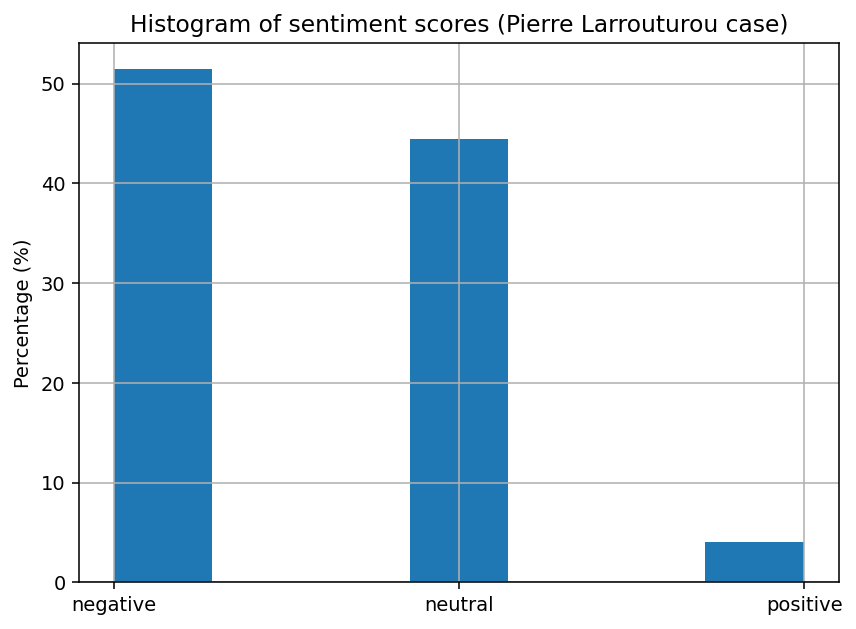

In [41]:
x = np.arange(n_labels)
bins = np.linspace(0, 2, 8)

fig, ax = plt.subplots (figsize=(7, 5), dpi=140)
plt.title ('Histogram of sentiment scores (Pierre Larrouturou case)')
#plt.hist (df ['messageSentiment.score'], bins, label=['label'] )
df1['tweetSentiment.score'].hist(bins=bins, weights=np.ones_like(df1[df1.columns[0]]) * 100. / len(df1))
plt.ylabel('Percentage (%)')
ax.set_xticks (x)
ax.set_xticklabels (list(labels_ids.keys()))
ax.grid(True)
#ax.legend (loc='upper right')
#plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()
plt.show ()

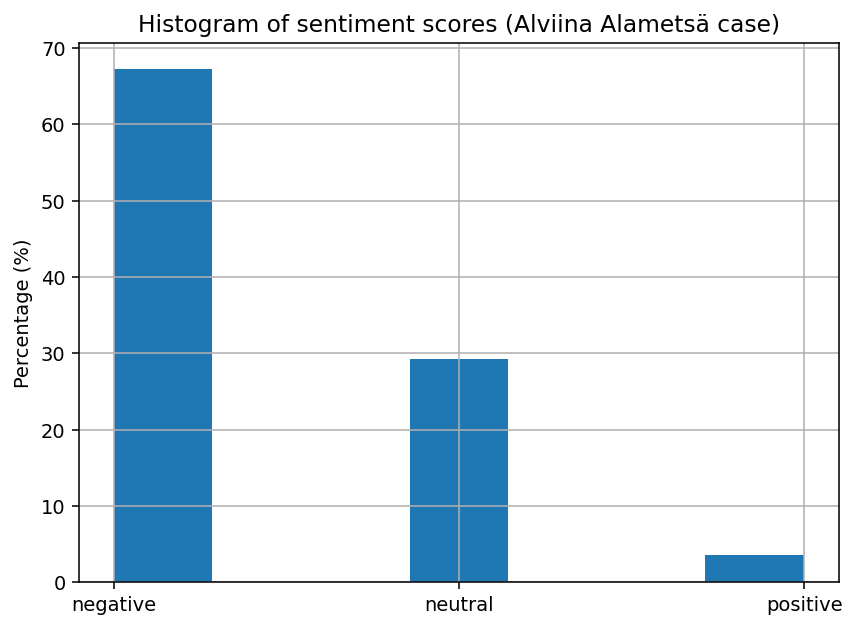

In [39]:
x = np.arange(n_labels)
bins = np.linspace(0, 2, 8)

fig, ax = plt.subplots (figsize=(7, 5), dpi=140)
plt.title ('Histogram of sentiment scores (Alviina Alametsä case)')
#plt.hist (df ['messageSentiment.score'], bins, label=['label'] )
df2['tweetSentiment.score'].hist(bins=bins, weights=np.ones_like(df2[df2.columns[0]]) * 100. / len(df2))
plt.ylabel('Percentage (%)')
ax.set_xticks (x)
ax.set_xticklabels (list(labels_ids.keys()))
ax.grid(True)
plt.show ()

Bar plot of top actors

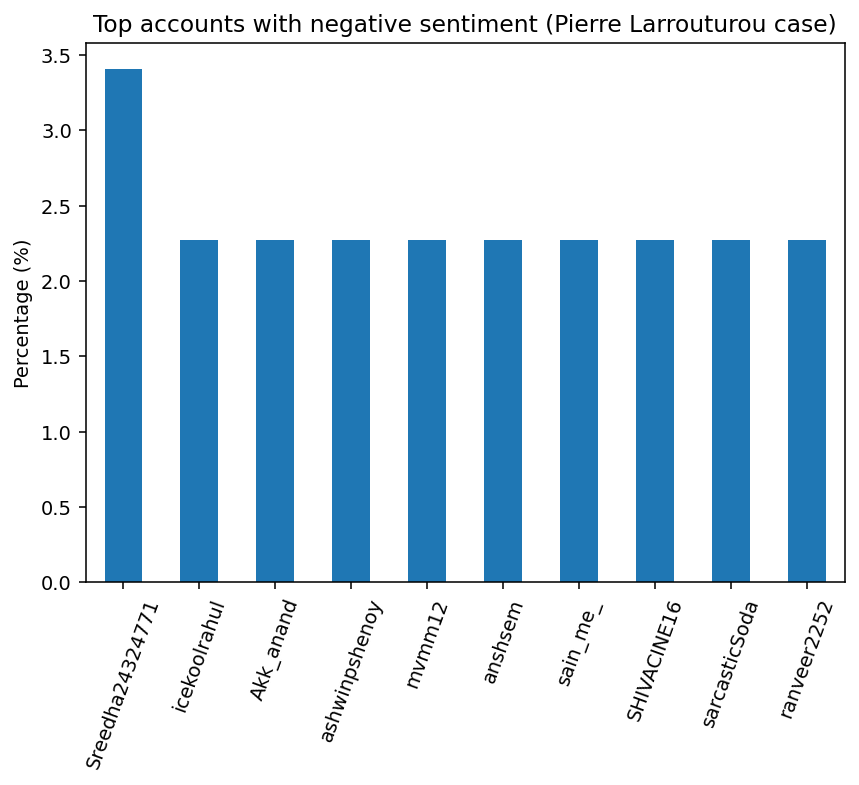

In [38]:
plt.figure(figsize=(7,5),dpi=140)

negative_sentiment = df1 [df1['tweetSentiment.score'] == 0]
negative_sentiment_percent = negative_sentiment ['username'].value_counts()*100/len(negative_sentiment)
negative_sentiment_percent[:10].plot(kind='bar')

plt.xticks(rotation = 70)

plt.title('Top accounts with negative sentiment (Pierre Larrouturou case)')
plt.ylabel('Percentage (%)')

plt.show()

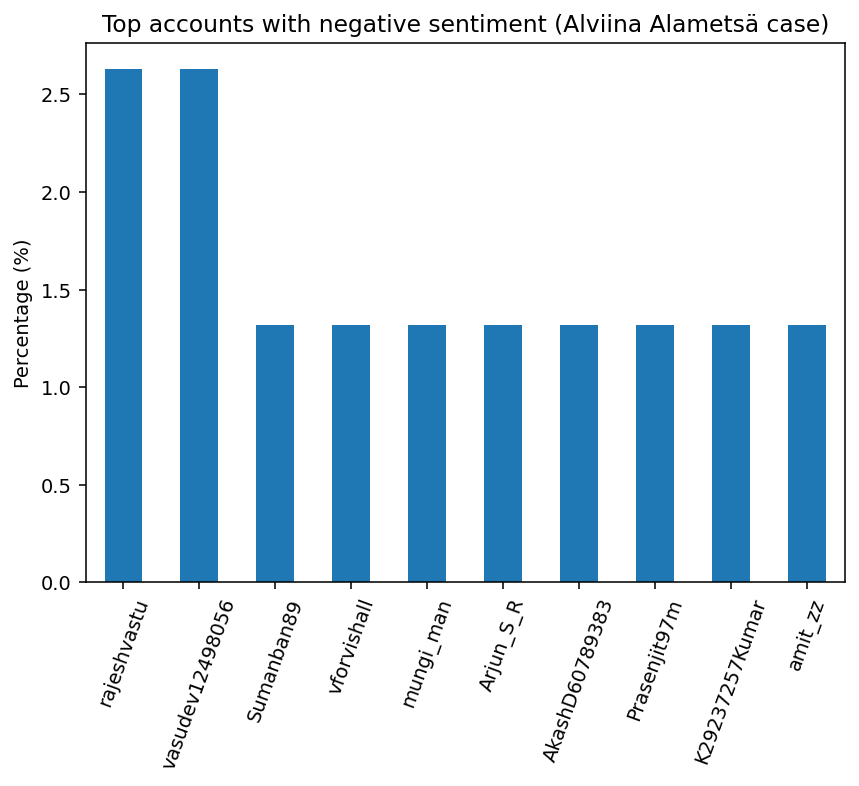

In [42]:
plt.figure(figsize=(7,5),dpi=140)

negative_sentiment = df2 [df2['tweetSentiment.score'] == 0]
negative_sentiment_percent = negative_sentiment ['username'].value_counts()*100/len(negative_sentiment)
negative_sentiment_percent[:10].plot(kind='bar')

plt.xticks(rotation = 70)

plt.title('Top accounts with negative sentiment (Alviina Alametsä case)')
plt.ylabel('Percentage (%)')

plt.show()